# SOSE surface salt sources $F = F_{A \rightarrow O} + F_{I \rightarrow O}$
`SFLUX = E - P - R`

From Ryan's Nature Geoscience 2016 paper, [supplemental doc](https://static-content.springer.com/esm/art%3A10.1038%2Fngeo2749/MediaObjects/41561_2016_BFngeo2749_MOESM303_ESM.pdf) (eqs S5-S9)

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [38]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [39]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.25b09dcf43d14f9ea7241416e4c0cfda/status,


In [31]:
client.close()
cluster.close()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:1014: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()


In [2]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import json
import fsspec
import gcsfs
import xmitgcm

In [3]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["SOSE"].to_dask()

In [4]:
coordsr = ds.coords.to_dataset().reset_coords()
dsr = ds.reset_coords(drop=True)
dsr

,Array,Chunk
Bytes,47.37 GiB,110.74 MiB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,439 Tasks,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,47.37 GiB,110.74 MiB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,439 Tasks,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [138]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
#WG model's boundaries (-77.87497˚S, -62.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0
upper_lat = 95
left_lon =  310
right_lon = 880

#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

coords = coordsr.roll(XC=700, roll_coords=True).isel(**lat_range, **lon_range).sel(time=slice('2006', '2010'))
ds = dsr.roll(XC=700, roll_coords=True).isel(**lat_range, **lon_range).sel(time=slice('2006', '2010'))

sit = ds.SIheff

In [12]:
coords.drF

<xarray.DataArray 'drF' (Z: 42)>
dask.array<open_dataset-a050d735e682b2f36299dae082225da8drF, shape=(42,), dtype=float32, chunksize=(42,), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
Attributes:
    long_name:      cell z size
    standard_name:  cell_z_size
    units:          m

In [13]:
vol = coords.rA * coords.drF

left_panel = ds.SIatmFW * vol
right_panel = (ds.SFLUX / ds.SIempmr) * vol

End of Section

In [9]:
ds.SIempmr

<xarray.DataArray 'SIempmr' (time: 438, YC: 95, XC: 570)>
dask.array<getitem, shape=(438, 95, 570), dtype=float32, chunksize=(1, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Ocean surface freshwater flux, > 0 increases salt
    standard_name:  SIempmr
    units:          kg/m^2/s

In [7]:
ds.SIempmr.attrs

{'long_name': 'Ocean surface freshwater flux, > 0 increases salt',
 'standard_name': 'SIempmr',
 'units': 'kg/m^2/s'}

In [8]:
ds.SIatmFW.attrs

{'long_name': 'Net freshwater flux from atmosphere & land (+=down)',
 'standard_name': 'SIatmFW',
 'units': 'kg/m^2/s'}

In [9]:
ds.SIsnPrcp.attrs

{'long_name': 'Snow precip. (+=dw) over Sea-Ice (area weighted)',
 'standard_name': 'SIsnPrcp',
 'units': 'kg/m^2/s'}

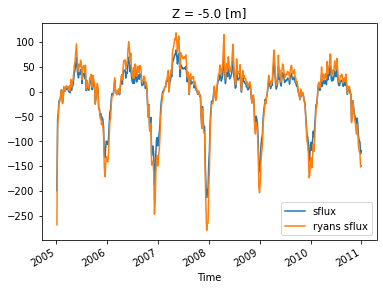

In [17]:
ds.SFLUX.sum(('XC','YC')).plot(label='sflux')
(ds.SIempmr*ds.SALT.isel(Z=0)).sum(('XC','YC')).plot(label='ryans sflux')
plt.legend();

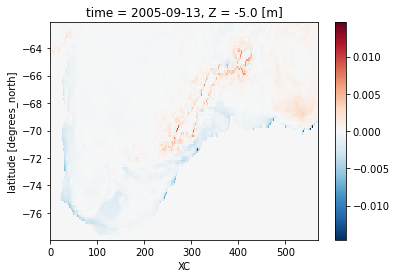

In [32]:
(ds.SFLUX - ds.SIempmr*ds.SALT.isel(Z=0)).sel(time='2005-09-14', method='nearest').drop('XC').plot()

**The residual between SFlux and SIempmr*SALT is the direct salt exchange between ocean and sea ice**

**sea ice does hold a small but non-zero amount of salt, and it can exchange it directly with the ocean. that's what the difference is**

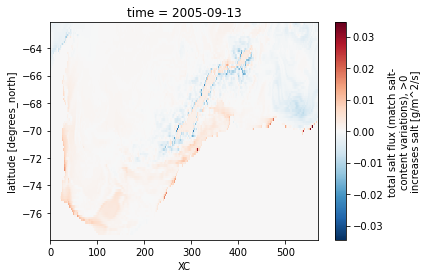

In [33]:
ds.SFLUX.sel(time='2005-09-14', method='nearest').drop('XC').plot()

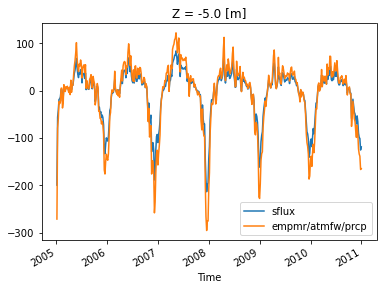

In [76]:
ds.SFLUX.sum(('XC','YC')).plot(label='sflux')
((ds.SIempmr- ds.SIatmFW + ds.SIsnPrcp)*ds.SALT.isel(Z=0)).sum(('XC','YC')).plot(label='empmr/atmfw/prcp')
plt.legend();

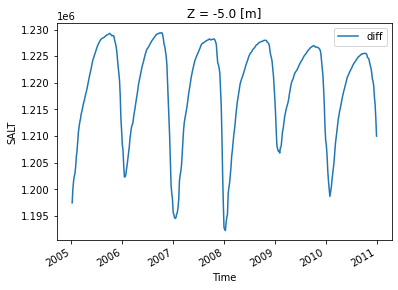

In [10]:
(ds.SIatmFW + ds.SIsnPrcp)*ds.SALT.isel(Z=0).sum(('XC','YC')).plot(label='diff')
plt.legend();

In [144]:
empmr = ds.SIempmr
atmfw = ds.SIatmFW
snprcp = ds.SIsnPrcp

runit2mass = 1 / 1.035e3 #rho

lhs = ds.SFLUX * runit2mass * coords.rA #psu m3 / s
f_ao = (atmfw - snprcp) * ds.SALT.isel(Z=0) * runit2mass * coords.rA #psu m3 / s
f_io = (empmr* ds.SALT.isel(Z=0) * runit2mass * coords.rA) - f_ao  #psu m3 / s

#rhs = (empmr - atmfw + snprcp) * ds.SALT.isel(Z=0) * runit2mass * coords.rA #psu m3 / s
#rhs = ds.SIempmr - ds.SIatmFW + ds.SIsnPrcp

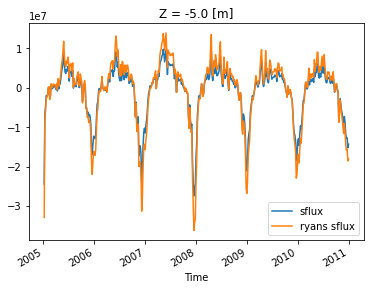

In [76]:
(ds.SFLUX* runit2mass * coords.rA).sum(('XC','YC')).plot(label='sflux')
(ds.SIempmr*ds.SALT.isel(Z=0)* runit2mass * coords.rA).sum(('XC','YC')).plot(label='ryans sflux')
plt.legend();

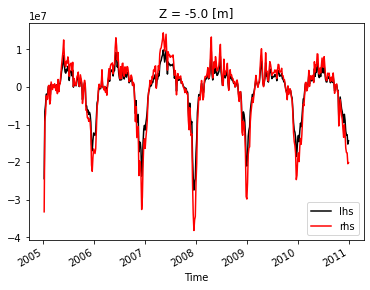

In [74]:
(lhs).sum(('XC', 'YC')).plot(label='lhs', color='k')
(rhs).sum(('XC', 'YC')).plot(label='rhs', color='r')
plt.legend();

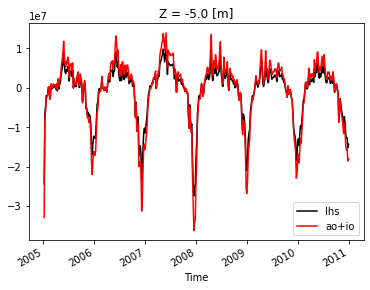

In [79]:
(lhs).sum(('XC', 'YC')).plot(label='lhs', color='k')
(f_io + f_ao).sum(('XC', 'YC')).plot(label='ao+io', color='r')
plt.legend();

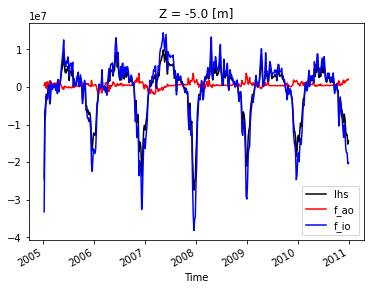

In [80]:
(lhs).sum(('XC', 'YC')).plot(label='lhs', color='k')
(f_ao).sum(('XC', 'YC')).plot(label='f_ao', color='r')
(f_io).sum(('XC', 'YC')).plot(label='f_io', color='b')
plt.legend();

In [81]:
diff = lhs - (f_ao + f_io)

Task exception was never retrieved
future: <Task finished name='Task-21624' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py:2016> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py", line 2025, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-21645' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py:2016> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py", line 2025, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-21697' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/pytho

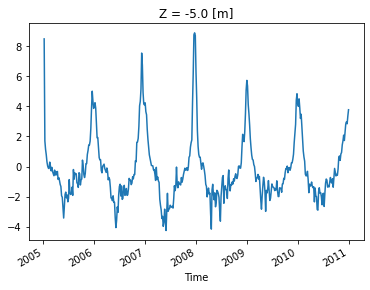

In [86]:
(diff.sum(('XC', 'YC'))/1e6).plot()

## Convert to transformation 

In [129]:
import json
from xhistogram.xarray import histogram

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

omega_surf_uncut = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/omega_surf.zarr'), consolidated=False)
omega_surf = omega_surf_uncut.sel(time=slice('2006', '2010'))
omega_surf.load()

<xarray.Dataset>
Dimensions:         (time: 366, sigma2_bin: 999)
Coordinates:
  * sigma2_bin      (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03
  * time            (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
Data variables:
    omega_surf      (time, sigma2_bin) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_surf_slt  (time, sigma2_bin) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_surf_th   (time, sigma2_bin) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [139]:
sigma2 = xr.apply_ufunc(jmd95numba.rho, ds.SALT, ds.THETA, 2000,
                            output_dtypes=[ds.SALT.dtype],
                            dask='parallelized').reset_coords(drop=True)#.load()
delta_sigma = 0.01
sigma_bins = np.arange(1027.5, 1037.5, delta_sigma)

In [140]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for adv and diff flux terms"""
    hist = histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                     weights=variable.fillna(0.), dim=['XC', 'YC', 'Z'])
    return hist / (-delta_sigma)

In [145]:
omega_surf_slt = omega_surf.omega_surf_slt
omega_f_ao = histogram_func(f_ao)
omega_f_io = histogram_func(f_io)

(-4.0, 4.0)

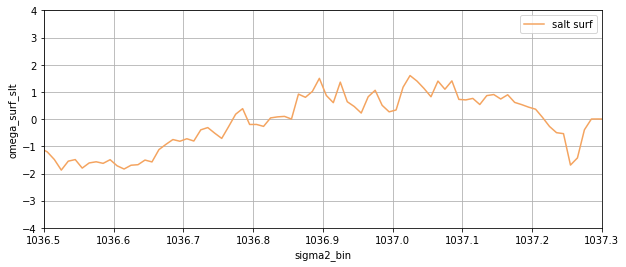

In [146]:
(omega_surf_slt/1e6).mean(dim='time').plot(figsize=(10,4), label='salt surf', color='sandybrown')
plt.legend()
plt.grid()
plt.xlim(1036.5, 1037.3)
plt.ylim(-4,4)

In [148]:
f_ao_bw = omega_f_ao.sel(sigma2_bin=slice(1037.125, 1037.5)).sum('sigma2_bin').load()
f_io_bw = omega_f_io.sel(sigma2_bin=slice(1037.125, 1037.5)).sum('sigma2_bin').load()

In [149]:
lhs_bw = omega_surf_slt.sel(sigma2_bin=slice(1037.125, 1037.5)).sum('sigma2_bin').load()

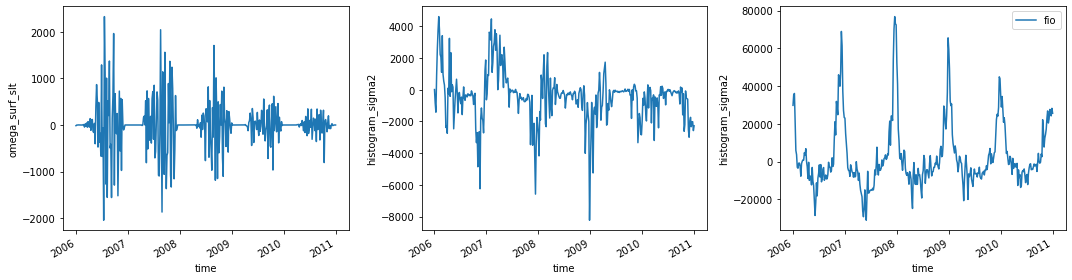

In [150]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
(lhs_bw/1e6).plot(label='lhs', ax=ax[0])
(f_ao_bw/1e6).plot(label='fao', ax=ax[1])
(f_io_bw/1e6).plot(label='fio', ax=ax[2])
plt.legend()
plt.tight_layout();

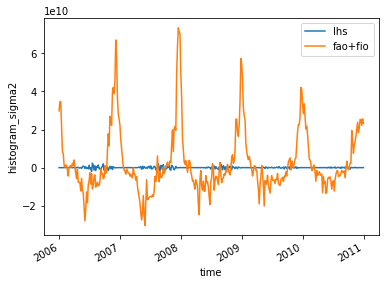

In [151]:
lhs_bw.plot(label='lhs')
(f_ao_bw + f_io_bw).plot(label='fao+fio')
plt.legend()

## Recreating Ryan's figs

In [7]:
ds.SIempmr.attrs

{'long_name': 'Ocean surface freshwater flux, > 0 increases salt',
 'standard_name': 'SIempmr',
 'units': 'kg/m^2/s'}

In [8]:
ds.SIatmFW.attrs

{'long_name': 'Net freshwater flux from atmosphere & land (+=down)',
 'standard_name': 'SIatmFW',
 'units': 'kg/m^2/s'}

In [9]:
ds.SIsnPrcp.attrs

{'long_name': 'Snow precip. (+=dw) over Sea-Ice (area weighted)',
 'standard_name': 'SIsnPrcp',
 'units': 'kg/m^2/s'}

In [88]:
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
#import plot_proj_to_latlon_grid

In [ ]:
proj = ccrs.SouthPolarStereo() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(1,3, figsize=(15, 15), subplot_kw=dict(projection=proj))

date = '2006-09-14'

# FLUX FROM ATM MOSTLY PRECIP

ax[0,0].set_extent([-70,30,-90,-60], crs=ccrs.PlateCarree())

ax[0,0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
ax[0,0].background_patch.set_facecolor('gainsboro')
ax[0,0].background_patch.set_alpha(0.2)

im = ax[0,0].pcolormesh(lon, lat, bw_mask.omega_trans.sel(time=date), transform=ccrs.PlateCarree(), cmap='seismic', vmin=-0.5, vmax=0.5)
cb = fig.colorbar(im, ax=ax[0,0], shrink=0.4)
cb.set_label("[Sv]", labelpad=12, fontsize=13)

g1 = ax[0,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax[0,0].set_title(r'$\Omega$', fontsize=16)

#ax[0,0].text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax[0,0].transAxes, fontsize=12)
#ax[0,0].text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax[0,0].transAxes, fontsize=12)

# IMPACT OF SEA ICE

ax[0,1].set_extent([-70,30,-90,-60], crs=ccrs.PlateCarree())

ax[0,1].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
ax[0,1].background_patch.set_facecolor('gainsboro')
ax[0,1].background_patch.set_alpha(0.2)

im = ax[0,1].pcolormesh(lon, lat, bw_mask.omega_mix.sel(time=date), transform=ccrs.PlateCarree(), cmap='seismic', vmin=-0.5, vmax=0.5)
cb = fig.colorbar(im, ax=ax[0,1], shrink=0.4)
cb.set_label("[Sv]", labelpad=12, fontsize=13)

g1 = ax[0,1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False
ax[0,1].set_title(r'$\Omega_{mix}$', fontsize=16)

# SFLUX/EmPmR (sum of first two)

ax[1,0].set_extent([-70,30,-90,-60], crs=ccrs.PlateCarree())

ax[1,0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
ax[1,0].background_patch.set_facecolor('gainsboro')
ax[1,0].background_patch.set_alpha(0.2)

im = ax[1,0].pcolormesh(lon, lat, bw_mask.omega_surf_slt.sel(time=date), transform=ccrs.PlateCarree(), cmap='seismic', vmin=-0.5, vmax=0.5)
cb = fig.colorbar(im, ax=ax[1,0], shrink=0.4)
cb.set_label("[Sv]", labelpad=12, fontsize=13)

g1 = ax[1,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False
ax[1,0].set_title(r'$\Omega_{surf^S}$', fontsize=16)

plt.suptitle('Bottom water transformation on 2006-09-14', fontsize=18, y=0.9)

plt.tight_layout();